# import

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [205]:
#%cd /content/drive/My Drive/Packages

import pandas as pd
import numpy as np
import scipy.sparse as sp
import time
import copy

#%cd /content/drive/My Drive/GitHub/minor-goodbooks-recommender

In [206]:
ratings = pd.read_csv('data/ratings.csv')
ratings
##too big!

,user_id,book_id,rating
0,1,258,5
1,2,4081,4
2,2,260,5
3,2,9296,5
4,2,2318,3
...,...,...,...
5976474,49925,510,5
5976475,49925,528,4
5976476,49925,722,4
5976477,49925,949,5


In [4]:
ratings.user_id.nunique()

53424

In [5]:
def sparsity(df):
  return len(df) / (df.user_id.nunique() * df.book_id.nunique())

sparsity(ratings)

0.011186880428271938

In [207]:
from sklearn.model_selection import train_test_split
_, random_users = train_test_split(ratings.user_id.unique(), test_size = 0.05, random_state = 322)

ratings_random = ratings.loc[ratings['user_id'].isin(random_users)]
ratings_random

,user_id,book_id,rating
629,58,26,1
630,58,58,4
631,58,18,5
632,58,14,3
633,58,2,3
...,...,...,...
5976331,17635,1922,5
5976455,10622,6810,4
5976457,10622,610,5
5976458,53358,253,5


In [7]:
sparsity(ratings_random)

0.011170451889014762

In [8]:
ratings_random.to_csv('data/ratings_random.csv', index=False)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f51cc5a6b50>]],
      dtype=object)

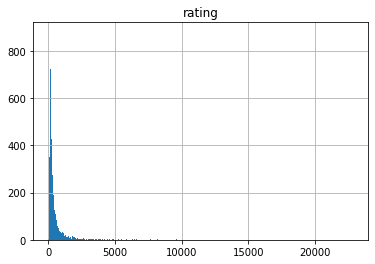

In [9]:
ratings.groupby('book_id').aggregate({'rating' : 'count'}).hist(bins=1000)

In [118]:
ratings_train, ratings_test = train_test_split(ratings_random, test_size = 0.2, random_state = 322)

# surprise

In [11]:
!pip install surprise

     |████████████████████████████████| 11.8MB 17.7MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1617566 sha256=9ff4869673c1924f844a665949d48e1ffe46319c4f94639edf9a882e0d9b12de
  Stored in directory: /root/.cache/pip/wheels/78/9c/3d/41b419c9d2aff5b6e2b4c0fc8d25c538202834058f9ed110d0
Successfully built scikit-surprise


In [12]:
%cd /content/drive/My Drive/Packages

from surprise import Reader, Dataset
from surprise.model_selection import KFold, GridSearchCV
from surprise import accuracy
from surprise.model_selection.validation import cross_validate
from surprise import NormalPredictor, KNNWithMeans, KNNWithZScore, SVD, SVDpp

%cd /content/drive/My Drive/GitHub/minor-goodbooks-recommender

/content/drive/My Drive/Packages
/content/drive/My Drive/GitHub/minor-goodbooks-recommender


In [13]:
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(ratings_random, reader)

In [14]:
data_train, data_test = Dataset.load_from_df(ratings_train, reader).build_full_trainset(), Dataset.load_from_df(ratings_test, reader)

In [15]:
data_full = Dataset.load_from_df(ratings_random, reader).build_full_trainset()

In [16]:
#from surprise.model_selection.split import train_test_split as surprise_train_test_split
#data_train, data_test = surprise_train_test_split(data)

In [17]:
kf = KFold(n_splits=5, random_state = 322)

In [18]:
def cross_val_score(estimator, X, scoring=None, cv=None):
  cvres_random = cross_validate(estimator, X, cv=cv, measures = [scoring])
  return cvres_random[f'test_{scoring}']

In [ ]:
alg_random = NormalPredictor()

cross_val_score(alg_random, data, cv=5, scoring = 'rmse').mean()

1.331807934109479

In [ ]:
start = time.time()
alg_knn = KNNWithMeans(k=5, verbose=False)

print(cross_val_score(alg_knn, data, cv=5, scoring = 'rmse').mean())
print(time.time()-start)

0.9174599862505092
56.99207329750061


In [ ]:
start = time.time()

alg_knn_z = KNNWithZScore(k=5, verbose=False)

print(cross_val_score(alg_knn_z, data, cv=5, scoring = 'rmse').mean())
print(time.time()-start)

0.9284487040641028
59.418858766555786


In [ ]:
param_grid = {'k': range(1, 10),
              'sim_options': {'name': ['msd', 'cosine', 'pearson'],
                              'user_based': [False, True]},
              'verbose' : [False]
              }

gs = GridSearchCV(KNNWithMeans, param_grid, measures=['rmse'], cv=kf)
gs.fit(data)

print(gs.best_score['rmse'])
print(gs.best_params['rmse'])

0.8916482192016723
{'k': 9, 'sim_options': {'name': 'msd', 'user_based': True}, 'verbose': False}


In [ ]:
param_grid = {'k': range(1, 10),
              'sim_options': {'name': ['msd', 'cosine', 'pearson'],
                              'user_based': [False, True]},
              'verbose' : [False]
              }

gsz = GridSearchCV(KNNWithZScore, param_grid, measures=['rmse'], cv=kf)
gsz.fit(data)

print(gsz.best_score['rmse'])
print(gsz.best_params['rmse'])

0.8957300167589836
{'k': 9, 'sim_options': {'name': 'msd', 'user_based': True}, 'verbose': False}


In [19]:
param_grid_svd = {'n_factors': range(10,110,10),
                  'verbose' : [False]
              }

gssvd = GridSearchCV(SVD, param_grid_svd, measures=['rmse'], cv=kf)
gssvd.fit(data)

print(gssvd.best_score['rmse'])
print(gssvd.best_params['rmse'])

0.8682623628854061
{'n_factors': 20, 'verbose': False}


In [ ]:
param_grid_svdpp = {'n_factors': range(10,50,4),
                  'verbose' : [False]
              }

gssvdpp = GridSearchCV(SVDpp, param_grid_svdpp, measures=['rmse'], cv=kf)
gssvdpp.fit(data)

print(gssvdpp.best_score['rmse'])
print(gssvdpp.best_params['rmse'])

# recall presision

In [ ]:
def predcit_list(algo, user_id, n=5, verbose=False):
  start = time.time()
  data_pred = data.build_full_trainset()
  algo.fit(data_pred)

  recs = pd.DataFrame({'book_id' : [], 'predicted_rating' : []})
  for id in ratings_random.book_id.unique():
    rat = algo.predict(user_id, id).est
    #print(rat)
    recs = recs.append({'book_id' : id, 'predicted_rating' : rat}, ignore_index=True)
    #print(recs)

  result = recs.loc[~recs['book_id'].isin(ratings_random.loc[ratings_random['user_id']==user_id].book_id)].sort_values('predicted_rating', ascending = False)
  if verbose == True:
    print('Seconds: ', time.time()-start)
  return result

In [ ]:
def recommend_list(user_ratings, ratings_data, algorithm, k=10, verbose = False, remove_rated = True):
  start = time.time()

  reader = Reader(rating_scale=(1, 5))
  data = Dataset.load_from_df(ratings_data, reader)
  data_full = Dataset.load_from_df(ratings_data.append(user_ratings), reader).build_full_trainset()

  algorithm.fit(data_full)

  preds = []
  for i in range(1, 9901):
    preds.append(algorithm.predict(user_ratings.user_id.unique()[0], i).est)
  
  recs = pd.DataFrame({'book_id' : range(1,9901), 'estimated_rating' : preds})
  if remove_rated:
    recs = recs.loc[~recs['book_id'].isin(user_ratings['book_id'])]
  recs = recs.sort_values('estimated_rating', ascending = False).head(k)
  if verbose:
    print('Seconds: ', time.time()-start)

  return recs

In [ ]:
algo_test = KNNWithMeans(k=9, verbose=False)
recommend_list(ratings.loc[ratings['user_id']==1], ratings_random, algo_test, verbose=True, remove_rated=False)

In [ ]:
algo_test = SVD(n_factors=20, verbose=False)
recommend_list(ratings.loc[ratings['user_id']==1], ratings_random, algo_test, verbose=True, remove_rated=False)

In [ ]:
def precision_recall_at_k(predictions, k=10, threshold=3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user.
    from collections import defaultdict
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. We here set it to 0.

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. We here set it to 0.

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    return precisions, recalls

In [ ]:
def precision_at_k(rec_list, )

In [ ]:
algo = KNNWithMeans(k=9, verbose=False)

algo.fit(data_train)
predictions = algo.test(data_test)
precisions, recalls = precision_recall_at_k(predictions, k=10, threshold=4)

print(sum(prec for prec in precisions.values()) / len(precisions))
print(sum(rec for rec in recalls.values()) / len(recalls))

In [ ]:
algo_svd = SVD(n_factors=20, verbose=False)

algo_svd.fit(data_train)
predictions = algo_svd.test(data_test)
precisions, recalls = precision_recall_at_k(predictions, k=5, threshold=4)

print(sum(prec for prec in precisions.values()) / len(precisions))
print(sum(rec for rec in recalls.values()) / len(recalls))

# spotlight

In [489]:
!pip install git+https://github.com/maciejkula/spotlight.git@master#egg=spotlight

  Cloning https://github.com/maciejkula/spotlight.git (to revision master) to /tmp/pip-install-vx4wvgzg/spotlight
  Running command git clone -q https://github.com/maciejkula/spotlight.git /tmp/pip-install-vx4wvgzg/spotlight
  Created wheel for spotlight: filename=spotlight-0.1.6-cp37-none-any.whl size=33921 sha256=5f68efd97db0b7b80889fb63c1086510c2e95bf44fe883b80b0819ef455ea7a2
  Stored in directory: /tmp/pip-ephem-wheel-cache-4bk4q3qb/wheels/de/0f/85/71b17c59d32cb9d29c31d4ffb16eb14f4cc153f1e28c7a3efb
Successfully built spotlight
ERROR: Operation cancelled by user
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 3021, in _dep_map
    return self.__dep_map
  File "/usr/local/lib/python3.7/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 2815, in __getattr__
    raise AttributeError(attr)
AttributeError: _DistInfoDistribution__dep_map

During handling of the above exception, another exception occurre

In [ ]:
import torch
import spotlight

In [ ]:
from spotlight.interactions import Interactions

data = Interactions(*[np.array(i) for _, i in ratings_random.items()])
data_train = Interactions(*[np.array(i) for _, i in ratings_train.items()])
data_test = Interactions(*[np.array(i) for _, i in ratings_test.items()])

In [ ]:
from spotlight.evaluation import rmse_score
from spotlight.factorization.explicit import ExplicitFactorizationModel

model = ExplicitFactorizationModel(loss='regression',
                                   embedding_dim=128,  # latent dimensionality
                                   n_iter=10,  # number of epochs of training
                                   batch_size=1024,  # minibatch size
                                   l2=1e-9,  # strength of L2 regularization
                                   learning_rate=1e-3,
                                   use_cuda=torch.cuda.is_available())
model.fit(data_train, verbose=True)

rmse_score(model, data_test)

Epoch 0: loss 13.886664521540695
Epoch 1: loss 3.418573094539888
Epoch 2: loss 1.1470414896379724
Epoch 3: loss 0.8211444383527077
Epoch 4: loss 0.7350682071350163
Epoch 5: loss 0.6972380533750476
Epoch 6: loss 0.6719108909496422
Epoch 7: loss 0.6488575676991705
Epoch 8: loss 0.6267038788406634
Epoch 9: loss 0.6040727829984329


0.86410011960886

In [ ]:
param_grid = {'embedding_dim': np.logspace(1,10, num=10, base=2),
              'n_iter' : range(5,20)}

In [ ]:
np.logspace(1,10, num=10, base=2)

array([   2.,    4.,    8.,   16.,   32.,   64.,  128.,  256.,  512.,
       1024.])

In [ ]:
for i in np.logspace(1,10, num=10, base=2):
  k = int(i)
  model = ExplicitFactorizationModel(loss='regression',
                                   embedding_dim=64,  # latent dimensionality
                                   n_iter=10,  # number of epochs of training
                                   batch_size=k,  # minibatch size
                                   l2=1e-9,  # strength of L2 regularization
                                   learning_rate=1e-3,
                                   use_cuda=torch.cuda.is_available())
  model.fit(data_train, verbose=False)

  print(i, rmse_score(model, data_test))

KeyboardInterrupt: ignored

In [ ]:
pred = model.predict(user_ids = 58)

In [ ]:
ratings_random.loc[ratings_random['user_id']==58].book_id

629          26
630          58
631          18
632          14
633           2
           ... 
5771155     279
5785098      61
5811024     702
5830792    9356
5853023    4576
Name: book_id, Length: 82, dtype: int64

In [ ]:
pred_list = pd.DataFrame(enumerate(pred), columns = ['book_id', 'predcited_rating'])
pred_list.loc[~pred_list['book_id'].isin(ratings_random.loc[ratings_random['user_id']==58].book_id)].sort_values(ascending=False, by = 'predcited_rating').head(10)

,book_id,predcited_rating
7593,7593,5.120577
8580,8580,4.996542
5529,5529,4.977715
9004,9004,4.920152
3920,3920,4.866500
7844,7844,4.842587
9566,9566,4.834001
2151,2151,4.804973
9537,9537,4.804045
4620,4620,4.792125


# lightfm

In [ ]:
!pip install lightfm

In [208]:
import pandas as pd
import numpy as np
import scipy.sparse as sp
import copy

In [209]:
books = pd.read_csv('data/books_transform.csv')
book_map = pd.read_csv('data/books.csv')[['id', 'title', 'authors']]
ratings = pd.read_csv('data/ratings.csv')
genres = sp.load_npz('data/genres.npz')
authors = sp.load_npz('data/authors.npz')
languages = sp.load_npz('data/languages.npz')

In [210]:
features = sp.hstack((
    #genres,
    authors,
    languages,
    #np.array(books['original_publication_year'])[:, None]
)).tocsr()
features

<10000x4330 sparse matrix of type '<class 'numpy.intc'>'
	with 20689 stored elements in Compressed Sparse Row format>

## lightfm

In [211]:
from lightfm import LightFM

In [212]:
from lightfm.data import Dataset

dataset = Dataset()

In [222]:
dataset.fit(ratings_random['user_id'].unique(), np.arange(1,10001))
#dataset.fit_partial(ratings['user_id'], ratings['book_id'])

In [217]:
def itervalues(df):
    for _, i in df.iterrows():
        yield i.values

In [223]:
(interactions, weights) = dataset.build_interactions(itervalues(ratings_random))

In [224]:
weights

<2672x10000 sparse matrix of type '<class 'numpy.float32'>'
	with 298176 stored elements in COOrdinate format>

In [225]:
from lightfm.cross_validation import random_train_test_split
weights_train, weights_test = random_train_test_split(weights, test_percentage=0.2, random_state=322)

In [227]:
data = {'train' : weights_train, 
        'test': weights_test, 
        'item_features' : None, 
        'item_labels' : pd.read_csv('data/books.csv')['title'].values, 
        'item_feature_labels' : None}

In [228]:
from lightfm import LightFM
from lightfm.evaluation import precision_at_k
from lightfm.evaluation import auc_score

model = LightFM(learning_rate=0.05, loss='warp')
model.fit(data['train'], epochs=10)

train_precision = precision_at_k(model, data['train'], k=10).mean()
test_precision = precision_at_k(model, data['test'], k=10, train_interactions=data['train']).mean()

train_auc = auc_score(model, data['train']).mean()
test_auc = auc_score(model, data['test'], train_interactions=data['train']).mean()

print('Precision: train %.2f, test %.2f.' % (train_precision, test_precision))
print('AUC: train %.2f, test %.2f.' % (train_auc, test_auc))

Precision: train 0.41, test 0.16.
AUC: train 0.93, test 0.90.


In [237]:
def evaluate(model_params, epochs=10):
    model = LightFM(**model_params, random_state=1)
    model.fit(data['train'], epochs=epochs)

    train_precision = precision_at_k(model, data['train'], k=10).mean()
    test_precision = precision_at_k(model, data['test'], k=10, train_interactions=data['train']).mean()

    train_auc = auc_score(model, data['train']).mean()
    test_auc = auc_score(model, data['test'], train_interactions=data['train']).mean()

    print('Precision: train %.2f, test %.2f.' % (train_precision, test_precision))
    print('AUC: train %.2f, test %.2f.' % (train_auc, test_auc))

In [258]:
for i in np.arange(10, 201, 10):
    print('N Components: ', i)
    evaluate(dict(no_components = i, learning_rate=0.05, loss='warp'))

N Components:  10
Precision: train 0.41, test 0.16.
AUC: train 0.92, test 0.90.
N Components:  20
Precision: train 0.45, test 0.18.
AUC: train 0.95, test 0.92.
N Components:  30
Precision: train 0.48, test 0.19.
AUC: train 0.96, test 0.93.
N Components:  40
Precision: train 0.50, test 0.20.
AUC: train 0.97, test 0.93.
N Components:  50
Precision: train 0.52, test 0.20.
AUC: train 0.97, test 0.93.
N Components:  60
Precision: train 0.54, test 0.20.
AUC: train 0.98, test 0.93.
N Components:  70
Precision: train 0.56, test 0.21.
AUC: train 0.98, test 0.93.
N Components:  80
Precision: train 0.58, test 0.22.
AUC: train 0.98, test 0.94.
N Components:  90
Precision: train 0.59, test 0.22.
AUC: train 0.99, test 0.94.
N Components:  100
Precision: train 0.61, test 0.22.
AUC: train 0.99, test 0.94.
N Components:  110
Precision: train 0.63, test 0.22.
AUC: train 0.99, test 0.94.
N Components:  120
Precision: train 0.64, test 0.22.
AUC: train 0.99, test 0.94.
N Components:  130
Precision: train 0

In [261]:
for i in np.arange(80, 111, 10):
    for j in np.random.exponential(0.05, 10):
        print('N Components: ', i)
        print('Learning rate:', j)
        evaluate(dict(no_components = i, learning_rate=0.05, loss='warp'))

N Components:  80
Learning rate: 0.019290148549252116
Precision: train 0.57, test 0.21.
AUC: train 0.98, test 0.94.
N Components:  80
Learning rate: 0.025272294673488207
Precision: train 0.57, test 0.22.
AUC: train 0.98, test 0.94.
N Components:  80
Learning rate: 0.018430494625011003
Precision: train 0.58, test 0.21.
AUC: train 0.98, test 0.94.
N Components:  80
Learning rate: 0.01327867393801306
Precision: train 0.58, test 0.21.
AUC: train 0.98, test 0.93.
N Components:  80
Learning rate: 0.11339931151783898
Precision: train 0.58, test 0.21.
AUC: train 0.98, test 0.94.
N Components:  80
Learning rate: 0.10547597662715243
Precision: train 0.58, test 0.21.
AUC: train 0.98, test 0.94.
N Components:  80
Learning rate: 0.15611439864262977
Precision: train 0.58, test 0.21.
AUC: train 0.98, test 0.94.
N Components:  80
Learning rate: 0.06269707542360263
Precision: train 0.58, test 0.21.
AUC: train 0.98, test 0.94.
N Components:  80
Learning rate: 0.01089150904639876
Precision: train 0.57, t

In [272]:
feats_kostyl = sp.hstack((
    features,
    sp.coo_matrix((10000,10000-features.shape[1])),
))
item_features = sp.identity(10000)+feats_kostyl

In [274]:
def evaluate_feats(model_params, epochs=10):
    model = LightFM(**model_params, random_state=1)
    model.fit(data['train'], item_features=item_features, epochs=epochs)

    train_precision = precision_at_k(model, data['train'], item_features=item_features, k=10, ).mean()
    test_precision = precision_at_k(model, data['test'], item_features=item_features, k=10, train_interactions=data['train']).mean()

    train_auc = auc_score(model, data['train'], item_features=item_features).mean()
    test_auc = auc_score(model, data['test'], train_interactions=data['train'], item_features=item_features).mean()

    print('Precision: train %.2f, test %.2f.' % (train_precision, test_precision))
    print('AUC: train %.2f, test %.2f.' % (train_auc, test_auc))

In [279]:
for i in np.arange(20):
    evaluate_feats(model_params = dict(no_components=100, loss='warp'), epochs=i)

Precision: train 0.01, test 0.00.
AUC: train 0.50, test 0.50.
Precision: train 0.40, test 0.15.
AUC: train 0.92, test 0.89.
Precision: train 0.47, test 0.18.
AUC: train 0.95, test 0.92.
Precision: train 0.50, test 0.20.
AUC: train 0.96, test 0.93.
Precision: train 0.53, test 0.21.
AUC: train 0.97, test 0.93.
Precision: train 0.55, test 0.22.
AUC: train 0.98, test 0.93.
Precision: train 0.57, test 0.23.
AUC: train 0.98, test 0.93.
Precision: train 0.59, test 0.23.
AUC: train 0.98, test 0.94.
Precision: train 0.60, test 0.24.
AUC: train 0.98, test 0.94.
Precision: train 0.61, test 0.24.
AUC: train 0.99, test 0.94.
Precision: train 0.62, test 0.24.
AUC: train 0.99, test 0.94.
Precision: train 0.62, test 0.24.
AUC: train 0.99, test 0.94.
Precision: train 0.63, test 0.24.
AUC: train 0.99, test 0.94.
Precision: train 0.64, test 0.24.
AUC: train 0.99, test 0.94.


KeyboardInterrupt: 

In [251]:
def sample_hyperparameters():
    """
    Yield possible hyperparameter choices.
    """

    while True:
        yield {
            "no_components": np.random.randint(16, 128),
            "learning_schedule": np.random.choice(["adagrad", "adadelta"]),
            #"loss": np.random.choice(["bpr", "warp", "warp-kos"]),
            "learning_rate": np.random.exponential(0.05),
            "item_alpha": np.random.exponential(1e-8),
            "user_alpha": np.random.exponential(1e-8),
            "max_sampled": np.random.randint(5, 15),
            "num_epochs": np.random.randint(5, 50),
        }


def random_search(train, test, num_samples=10, num_threads=1):
    """
    Sample random hyperparameters, fit a LightFM model, and evaluate it
    on the test set.

    Parameters
    ----------

    train: np.float32 coo_matrix of shape [n_users, n_items]
        Training data.
    test: np.float32 coo_matrix of shape [n_users, n_items]
        Test data.
    num_samples: int, optional
        Number of hyperparameter choices to evaluate.


    Returns
    -------

    generator of (auc_score, hyperparameter dict, fitted model)

    """
    import itertools
    for hyperparams in itertools.islice(sample_hyperparameters(), num_samples):
        num_epochs = hyperparams.pop("num_epochs")

        model = LightFM(**hyperparams, loss='bpr', random_state=1)
        model.fit(data['train'], epochs=num_epochs, num_threads=num_threads)

        auc = auc_score(model, data['test'], train_interactions=data['train'], num_threads=num_threads).mean()
        prec = precision_at_k(model, data['test'], k=10, train_interactions=data['train']).mean()
        
        hyperparams["num_epochs"] = num_epochs
        print(auc, prec, hyperparams)
        yield (auc, prec, hyperparams, model)

In [252]:
(auc, prec, hyperparams, model) = max(random_search(data['train'], data['test'], num_threads=1), key=lambda x: x[1])
print("Best roc_auc {}, precision {} at {}".format(auc, prec, hyperparams))

0.87021804 0.16796407 {'no_components': 68, 'learning_schedule': 'adagrad', 'learning_rate': 0.025226879613373162, 'item_alpha': 8.908310526277831e-10, 'user_alpha': 4.9360491549262306e-09, 'max_sampled': 11, 'num_epochs': 36}
0.86321425 0.13529192 {'no_components': 17, 'learning_schedule': 'adagrad', 'learning_rate': 0.12685879415614829, 'item_alpha': 1.0765226131936803e-08, 'user_alpha': 4.297429548223116e-08, 'max_sampled': 7, 'num_epochs': 7}
0.87430525 0.16021708 {'no_components': 100, 'learning_schedule': 'adadelta', 'learning_rate': 0.029186758987243763, 'item_alpha': 1.1672166047888302e-08, 'user_alpha': 1.3055982574666412e-08, 'max_sampled': 14, 'num_epochs': 34}
0.72541046 0.16208833 {'no_components': 91, 'learning_schedule': 'adagrad', 'learning_rate': 0.034357757996927245, 'item_alpha': 9.511138218904433e-09, 'user_alpha': 2.1003039203482873e-09, 'max_sampled': 8, 'num_epochs': 6}
0.61273944 0.10093563 {'no_components': 105, 'learning_schedule': 'adagrad', 'learning_rate': 

KeyboardInterrupt: 

In [366]:
model = LightFM(learning_rate=0.05, loss='warp')
model.fit(weights, epochs=10)

In [319]:
def sample_recommendation_original(model, data, user_id, k=10, print_output=True):

  n_users, n_items = data['train'].shape

  known_positives = data['item_labels'][data['train'].tocsr()[user_id].indices]
  scores = model.predict(user_id, np.arange(n_items))
  top_items = data['item_labels'][np.argsort(-scores)]
  if print_output == True:
    for x in known_positives[:k]:
      print("        %s" % x)
    print("     Recommended:")
    for x in top_items[:k]:
      print("        %s" % x)

In [320]:
sample_recommendation_original(model, data, 0)

        The Hunger Games (The Hunger Games, #1)
        Harry Potter and the Sorcerer's Stone (Harry Potter, #1)
        Twilight (Twilight, #1)
        To Kill a Mockingbird
        The Fault in Our Stars
        The Hobbit
        The Catcher in the Rye
        Angels & Demons  (Robert Langdon, #1)
        Pride and Prejudice
        The Kite Runner
     Recommended:
        The Giver (The Giver, #1)
        Memoirs of a Geisha
        The Hobbit
        To Kill a Mockingbird
        Divine Secrets of the Ya-Ya Sisterhood
        Like Water for Chocolate
        The Catcher in the Rye
        Angela's Ashes (Frank McCourt, #1)
        Siddhartha
        Life of Pi


In [147]:
def fetch_user_ratings_id(user_id):
  pd.options.mode.chained_assignment = None
  user_ratings = ratings.loc[ratings['user_id']==user_id, :]
  user_ratings['user_id'] = 0
  return user_ratings

## setup

In [7]:
from sklearn.model_selection import train_test_split
_, random_users = train_test_split(ratings.user_id.unique(), test_size = 0.05, random_state = 322)

ratings_random = ratings.loc[ratings['user_id'].isin(random_users)]
ratings_random.sort_values('user_id')

,user_id,book_id,rating
4321395,13,143,4
4321347,13,1522,3
4321345,13,396,4
4321344,13,930,4
4321343,13,31,5
...,...,...,...
5387830,53396,3037,5
5387831,53396,3169,5
5387833,53396,2993,5
5387813,53396,4078,3


In [31]:
#внимание, костыль.
features_kostyl = sp.hstack((
    features,
    sp.coo_matrix((10000,10000-features.shape[1])),
))
features_kostyl

<10000x10000 sparse matrix of type '<class 'numpy.float64'>'
	with 20689 stored elements in COOrdinate format>

In [33]:
pd.DataFrame.sparse.from_spmatrix(features)

,0,1,2,3,4,5,6,7,8,9,...,4320,4321,4322,4323,4324,4325,4326,4327,4328,4329
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [45]:
def itervalues2(df):
    for i, r in df.iterrows():
        yield i, r.values

In [40]:
itervalues2(pd.DataFrame.sparse.from_spmatrix(features))

<generator object itervalues at 0x0000020B8E851A50>

In [ ]:
from lightfm.data import Dataset

dataset = Dataset()

In [84]:
test_feats = pd.DataFrame({'col1':np.repeat(69, 10), 'col2':np.arange(10)})
test_feats

,col1,col2
0,69,0
1,69,1
2,69,2
3,69,3
4,69,4
5,69,5
6,69,6
7,69,7
8,69,8
9,69,9


In [85]:
for i in itervalues2(test_feats):
    print(i)

(0, array([69,  0]))
(1, array([69,  1]))
(2, array([69,  2]))
(3, array([69,  3]))
(4, array([69,  4]))
(5, array([69,  5]))
(6, array([69,  6]))
(7, array([69,  7]))
(8, array([69,  8]))
(9, array([69,  9]))


In [86]:
def itervalues_test(df):
    for i, r in df.iterrows():
        yield i, dict(zip(np.arange(df.shape[1]), r))

In [88]:
dataset.fit(users = np.arange(10),
            items = np.arange(10))
test = dataset.build_item_features(itervalues_test(test_feats), normalize = False)
pd.DataFrame.sparse.from_spmatrix(test)

,0,1,2,3,4,5,6,7,8,9
0,70.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,69.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,69.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,69.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,69.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
5,69.0,5.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
6,69.0,6.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
7,69.0,7.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
8,69.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
9,69.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [47]:
features_kostyl

<10000x10000 sparse matrix of type '<class 'numpy.float64'>'
	with 20689 stored elements in COOrdinate format>

In [91]:
def setup_lightfm(ratings_data, user_feats=None, item_feats=None):
    #from lightfm.data import Dataset
    from lightfm import LightFM
    #dataset = Dataset()
    #dataset.fit(
    #    users = np.arange(ratings['user_id'].nunique()+1),
    #    items = np.arange(ratings['book_id'].nunique()),
    #)
    
    #def itervalues2(df):
    #    for i, r in df.iterrows():
    #        yield i, r.values
    #item_features = dataset.build_item_features(itervalues2(pd.DataFrame.sparse.from_spmatrix(item_feats)))

    ratings_data_local = copy.deepcopy(ratings_data)
    ratings_data_local['user_id'] = ratings_data_local['user_id'].replace(
        dict(zip(ratings_data_local['user_id'].unique(), np.arange(ratings_data_local['user_id'].nunique()))))

    interactions = sp.coo_matrix((
        np.repeat(1, ratings_data_local.shape[0]), 
        (ratings_data_local['user_id'], ratings_data_local['book_id']-1)
    ))
    
    interactions_upd = sp.vstack((
        sp.coo_matrix((1,10000)),
        interactions
    ))
    weights = sp.coo_matrix((
        ratings_data_local['rating'], 
        (ratings_data_local['user_id'], ratings_data_local['book_id']-1)
    ))
    weights_upd = sp.vstack((
        sp.coo_matrix((1,10000)),
        weights
    ))
    
    feats_kostyl = sp.hstack((
        item_feats,
        sp.coo_matrix((10000,10000-item_feats.shape[1])),
    ))
    item_features = sp.identity(10000)+feats_kostyl
    
    model = LightFM(learning_rate=0.05, loss='bpr', random_state=1)
    model.fit(
        interactions = interactions_upd,
        #user_features = user_feats,
        item_features = item_features,
        sample_weight = weights_upd,
        epochs = 1
    )
    
    print(weights_upd.shape)
    #print(item_feats.shape)
    return model#, item_features

In [92]:
model = setup_lightfm(ratings_random, item_feats = features)

(2673, 10000)


In [23]:
model.predict(1, np.arange(10000))

array([-0.65026385, -0.7456271 , -0.73611665, ..., -0.7176436 ,
       -0.7233876 , -0.7262109 ], dtype=float32)

In [93]:
def recommend_list_lightfm(user_ratings, ratings_data, algorithm,
                           user_features=None, item_features=None, verbose = False, remove_rated = True, n=10):
    #dataset_local = copy.deepcopy(dataset)
    
    #(new_interactions, new_weights) = dataset_local.build_interactions(itervalues(ratings_data.append(user_ratings)))
    
    ratings_data_local = copy.deepcopy(ratings_data)
    
    new_ratings_data = user_ratings.append(ratings_data_local)
    new_ratings_data['user_id'] = new_ratings_data['user_id'].replace(
        dict(zip(new_ratings_data['user_id'].unique(), np.arange(new_ratings_data['user_id'].nunique()))))
    
    new_interactions = sp.coo_matrix((
        np.repeat(1, new_ratings_data.shape[0]), 
        (new_ratings_data['user_id'], new_ratings_data['book_id']-1)
    ))
    new_weights = sp.coo_matrix((
        new_ratings_data['rating'], 
        (new_ratings_data['user_id'], new_ratings_data['book_id']-1)
    ))
    
    feats_kostyl = sp.hstack((
        item_features,
        sp.coo_matrix((10000,10000-item_features.shape[1])),
    ))
    item_features = sp.identity(10000)+feats_kostyl
    
    algorithm_local = copy.deepcopy(algorithm)
    algorithm_local.fit_partial(interactions = new_interactions, 
                                #user_features = user_features, 
                                item_features = item_features,
                                sample_weight = new_weights
                               )
    algorithm_local.item_biases = np.zeros_like(algorithm_local.item_biases)

    #data = {'train' : new_weights,
    #        'item_features' : None,
    #        'item_labels' : book_map['title'].values, 
    #        'item_feature_labels' : None}
    
    item_labels = book_map['title'].values
    n_users, n_items = new_weights.shape
    user_id = 0

    known_positives = item_labels[new_weights.tocsr()[user_id].indices]
    scores = algorithm_local.predict(user_id, np.arange(n_items))
    top_items = item_labels[np.argsort(-scores)]

    if remove_rated:
        #return [i for i in top_items if i not in known_positives][:n]
        return top_items[~np.isin(top_items, known_positives)][:n]
    else:
        return top_items[:n]

In [94]:
recommend_list_lightfm(fetch_user_ratings_id(1), ratings_random, model, item_features=features)

array(['Dream Country (The Sandman #3)', 'Master of the Game',
       'Girl in Translation',
       'The Killer Angels (The Civil War Trilogy, #2)',
       'Bone: The Complete Edition',
       "P.S. I Still Love You (To All the Boys I've Loved Before, #2)",
       'Still Life with Woodpecker',
       'Beautiful Bastard (Beautiful Bastard, #1)',
       'The Cruelest Month (Chief Inspector Armand Gamache, #3)',
       'The Winter Sea (Slains, #1)'], dtype=object)

In [213]:
class LightFM_Recommender():
    def __init__(self):
        pass
    
    def build_interactions(self, ratings_data):
        interactions = sp.coo_matrix((
            np.repeat(1, ratings_data.shape[0]),
            (ratings_data['user_id'], ratings_data['book_id']-1)
        ))
        if interactions.shape[1]<self.n_items:
            interactions = sp.hstack((
                interactions,
                sp.coo_matrix((1, self.n_items-interactions.shape[1])),
            ))
        weights = sp.coo_matrix((
            ratings_data['rating'],
            (ratings_data['user_id'], ratings_data['book_id']-1)
        ))
        if weights.shape[1]<self.n_items:
            weights = sp.hstack((
                weights,
                sp.coo_matrix((1, self.n_items-weights.shape[1])),
            ))
        
        return interactions, weights
    
    def update_interacions(self, user_ratings=None):
        if user_ratings is not None:
            user_vector = sp.coo_matrix((
                np.repeat(1, user_ratings.shape[0]),
                (user_ratings['user_id'], user_ratings['book_id']-1)
            ))
            if user_vector.shape[1]<self.n_items:
                user_vector = sp.hstack((
                    user_vector,
                    sp.coo_matrix((1, self.n_items-user_vector.shape[1])),
                ))
        else:
            user_vector = sp.coo_matrix((1, self.n_items))
        
        interactions_upd = sp.vstack((
            user_vector,
            self.interactions
        ))
        weights_upd = sp.vstack((
            user_vector,
            self.weights
        ))
        return interactions_upd, weights_upd
            
    def build_item_features(self, item_features):
        feats_kostyl = sp.hstack((
            item_features,
            sp.coo_matrix((item_features.shape[0], item_features.shape[0]-item_features.shape[1])),
        ))
        return sp.identity(item_features.shape[0])+feats_kostyl
        
        
    def fit(self, ratings_data, algorithm, user_feats=None, item_feats=None):
        self.n_users = ratings_data['user_id'].nunique()
        self.n_items = 10000
        self.ratings_data = copy.deepcopy(ratings_data)
        ### reset user id
        self.ratings_data['user_id'] = self.ratings_data['user_id'].replace(
            dict(zip(self.ratings_data['user_id'].unique(), np.arange(self.n_users))))
        ###
        self.algorithm = copy.deepcopy(algorithm)
        self.interactions, self.weights = self.build_interactions(self.ratings_data)
        self.item_features = self.build_item_features(item_feats)
        
        interactions_upd, weights_upd = self.update_interacions()
        
        self.algorithm.fit(
            interactions = interactions_upd,
            #user_features = user_feats,
            item_features = self.item_features,
            sample_weight = weights_upd,
            epochs = 1
        )
        return self
        
    def predict_list(self, user_ratings, n=10, handle_series=False):
        interactions_new, weights_new = self.update_interacions(user_ratings)
        
        algorithm_local = copy.deepcopy(self.algorithm)
        algorithm_local.fit_partial(
            interactions = interactions_new,
            #user_features = user_features,
            item_features = self.item_features,
            sample_weight = weights_new
        )
        algorithm_local.item_biases = np.zeros_like(algorithm_local.item_biases)
        
        titles = pd.read_csv('data/books.csv')['title'].values
        known_positives = titles[weights_new.tocsr()[0].indices]
        scores = algorithm_local.predict(0, np.arange(self.n_items))
        top_items = titles[np.argsort(-scores)]
        
        return top_items[:n]+1

In [203]:
model = LightFM(learning_rate=0.05, loss='bpr', random_state=1)
lightfm_hybrid = LightFM_Recommender()
lightfm_hybrid.fit(ratings_random, model, item_feats = features)

In [204]:
reclist = lightfm_hybrid.predict_list(fetch_user_ratings_id(3))
reclist

TypeError: can only concatenate str (not "int") to str

In [201]:
map_books(reclist)

[['The Red Badge of Courage', 'Stephen Crane'],
 ['City of Heavenly Fire (The Mortal Instruments, #6)', 'Cassandra Clare'],
 ['Chess Story',
  'Stefan Zweig, Joel Rotenberg, Hans Hausmann, Dirk Muller, Peter Gay, Willy Trenk-Trebitsch, Mario Adorf, Gert Westphal'],
 ['Evening Class', 'Maeve Binchy'],
 ['The Cruelest Month (Chief Inspector Armand Gamache, #3)', 'Louise Penny'],
 ['Watership Down (Watership Down, #1)', 'Richard Adams'],
 ['One Foot in the Grave (Night Huntress, #2)', 'Jeaniene Frost'],
 ['Sea Swept (Chesapeake Bay Saga, #1)', 'Nora Roberts'],
 ['Just Kids', 'Patti Smith'],
 ['Siddhartha', 'Hermann Hesse, Hilda Rosner']]

In [ ]:
fetch_user_ratings_id(1)

In [21]:
new_ratings_data = fetch_user_ratings_id(1).replace(999999, 0).append(ratings_random)

new_ratings_data['user_id'] = new_ratings_data['user_id'].replace(
    dict(zip(new_ratings_data['user_id'].unique(), np.arange(new_ratings_data['user_id'].nunique()))))

new_weights = sp.coo_matrix((
        new_ratings_data['rating'], 
        (new_ratings_data['user_id'], new_ratings_data['book_id']-1)
    ))

new_weights.shape

(2673, 10000)

In [14]:
ratings_random.user_id.nunique()

2672

In [106]:
new_weights = sp.coo_matrix((
        new_ratings_data['rating'], 
        (new_ratings_data['user_id'], new_ratings_data['book_id']-1)
    ))

In [275]:
features.shape[1]

6828

In [49]:
from lightfm import LightFM

In [470]:
print(dataset, model)

<lightfm.data.Dataset object at 0x7f517dab8fd0> <lightfm.lightfm.LightFM object at 0x7f517da27bd0>


In [46]:
features.shape[1]

4330

In [468]:
fetch_user_ratings_id(3)

,user_id,book_id,rating
71490,999999,8452,1
71491,999999,522,1
71492,999999,4788,2
71493,999999,150,2
71494,999999,9962,1
...,...,...,...
342371,999999,4090,5
493529,999999,32,2
493748,999999,58,2
493749,999999,15,3
